# The emergence of Pulse Gate

Lately IBM Quantum Experience team officially announced the retirement of OpenPulse-enabled backends, namely `ibmq_armonk`, `ibmq_santiago`, and `ibmq_bogota`. In addition the method of sending `Schedule` directly to the backend is now depricated, i.e. we can no longer send pulse builder instruction explicitly down to the hardware. Instead, circuits have become the standard representation for executing quantum algorithms, at least Qiskit. As you may alredy know, circuits comprise of logical gates which operating in a sequential manner, and culminated with measurement on diffenting levels. The problem with logical gates is that they are pre-calibrated, meaning that they're the abstract equivalence of a lower-level pulse that have been priorily determined in terms of shape, amplitude, frequency, etc. This puts a constraint on the implementation of optimal or higher level control (qudit).

Luckily, with `pulse_gate` we are now able to calibrate logical gates on circuit level. More precisely, pulse gate allows us to map a logical gate to a Qiskit Pulse `Schedule`, which can be programmed to produce the exact time dynamics of the control field that we expected. This is of importance for tasks that require a deeper understanding of the physical laws that govern the transmon system.

The tutorial is strutured as follow,

1. First, we learn to map a calibration to a logical gate & conduct a simple spectroscopy
2. Second, we will reproduce the Rabi oscillation experiment on ibmq_manila
3. Third, we will try to measure results on first level (IQ signals)

# Map a calibration to logical gates

As we said, now every job sending to backend must be under the circuit-paradigm. Let us first create a simple circuit that contains two quantum logical gate, the $X$-gate default version and calibrated version. The circuit is culminated with a measurement that project the state of the qubit onto a classical bit.

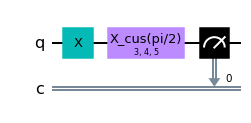

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate

circ = QuantumCircuit(1, 1) # 1 quantum bit & 1 classical bit

circ.x(0) # X-operation on qubit 0, the DEFAULT version

# Let us now create a calibrated version, using our own instruction shedule. 
# Let us call the calibrated version the X_cus gate.

X_cus = Gate('X_cus(pi/2)', 1, [3,4,5])

circ.append(X_cus, [0])
circ.measure(0, 0) # perform measurement on qubit 0, project on classical bit 0
                   # note that this is a measurement on level 2

circ.draw('mpl')

Now that we have the circuit, we can create a `schedule` that *calibrate* the $X$-operation that we have specified in the circuit. The process of construction a `schedule` is detailed [here](https://github.com/Qiskit/qiskit-tutorials/blob/998e37f75ab52de4b6442ca8f8ffaa32276b8456/tutorials/circuits_advanced/06_building_pulse_schedules.ipynb). As of 2021, every backend now has pulse access. Let us call the `ibmq_belem` as the backend for our experiment.

In [4]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

ibmqfactory.load_account:WARNING:2022-05-06 20:43:39,605: Credentials are already in use. The existing account in the session will be replaced.


We can do a sanity check to see the parameters of X pulse on `ibmq_manila`, so we will mimic it in our calibration schedule. 

In [7]:
inst_sched_map_man = backend.defaults().instruction_schedule_map

qubit = 0 # qubit 0 on ibmq_manila (there are 5 of them)
x_man = inst_sched_map_man.get('x', qubits=[qubit])

x_man.instructions

((0,
  Play(Drag(duration=160, amp=(0.19555861812669767+0j), sigma=40, beta=-0.5504508376305821, name='Xp_d0'), DriveChannel(0), name='Xp_d0')),)

In [125]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


So, on `ibmq_manila` the X-gate is defined as a Drag pulse of duration 160dt, an amplitude $A$ of $\approx 0.196+0j$. The correction parameters of Drag pulse are $\sigma=40$ and $\beta \approx -0.56$. Reminder: The first-order DRAG correction to a Gaussian shaped pulse 

$$\Omega_x(t) = A\exp\left[\dfrac{-t^2}{2\sigma^2}\right]$$

with amplitude $A$ and width $\sigma$, is

$$\Omega_{DRAG}(t) = \Omega_x(t)+i\dfrac{\beta}{\Delta}\dfrac{d\Omega_x}{dt}$$

The imaginary component of the DRAG pulse eliminates leakage out of the computational subspace. If you were to draw the shape of our pulse, the imaginary part will be the lower part.

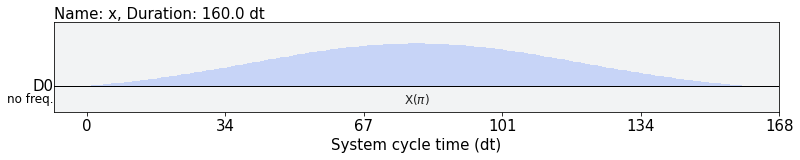

In [9]:
x_man.draw()

We will mimic the $X$-pulse priorily defined by IBMQ. However, we will add a little salt to it by multiply the amplitude by 0.5, i.e. the resulting effect would be rotating $\pi/2$ the x-axis around the Bloch sphere. Measurement along the pauli $Z$-basis will yield an equal probability of the qubit being in either computational subspaces.

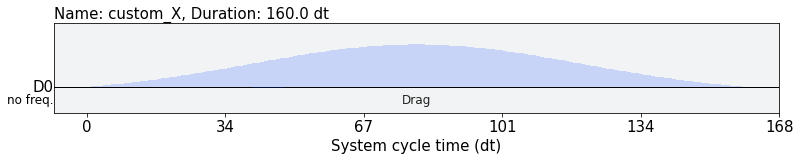

In [10]:
from qiskit import pulse
from qiskit.pulse.library import Drag

with pulse.build(backend, name='custom_X') as X_sched:
    pulse.play(Drag(duration=160, amp=(0.19587717637708868*0.5+0j), sigma=40, beta=-0.5598528148942019), pulse.drive_channel(0))
   
X_sched.draw()

Now we add the instructed calibration to the original circuit.

In [11]:
circ.add_calibration(X_cus, [0], X_sched)

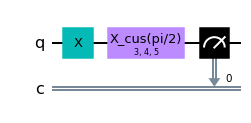

In [12]:
from qiskit import transpile

circ = transpile(circ, backend)

circ.draw('mpl', idle_wires=False)

In [ ]:
job = backend.run(circ, shots=1024, meas_level=2)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

In [ ]:
from qiskit.visualization import plot_bloch_multivector, plot_histogram
counts = job.result().get_counts()
plot_histogram(counts)

# Qubit Spectroscopy

Being able to realize quantum logic gate by means of pulses naturally leads to the problem of calibrating pulses. Here we reproduce the process of calibrating pulses parameters, namely frequency and amplitude, using the new Pulse Gate feature. The chosen backend is `ibmq_manila`. 

Most of the procedure is akin to that presented [here](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html).

We have got our basic dependencies set up and ready to go above, so let us get straight to the frequency sweep.

Let us first generate a circuit for each frequency step

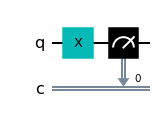

In [94]:
freq_circ = QuantumCircuit(1, 1)
freq_circ.x(0)
freq_circ.measure(0, 0)

freq_circ.draw('mpl', idle_wires=True)

## Finding qubit frequency using Frequency Sweep

We define the frequency range that will be swept in search of the qubit. Since this can be arbitrarily broad, we restrict ourselves to a window of 40 MHz around the estimated qubit frequency in `backend.defaults()`. We step the frequency in units of 1 MHz.

In [126]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0
# We will define memory slot channel 0.
mem_slot = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.962271822697221 GHz.
The sweep will go from 4.94227182269722 GHz to 4.9822718226972205 GHz in steps of 1.0 MHz.


In [129]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of_16(sec/dt)

Calibrating the `sweep_gate` using the `sweep_sched` schedule.

In [139]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.

# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us                           # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8               # This is a truncating parameter, because gaussians don't have 
                                                       # a natural finite length
drive_amp = 0.05

# Create the base schedule
# Start with drive pulse acting on the drive channel
freq_circs = []
for freq_off in frequencies_Hz: 
    freq_circ_off = deepcopy(freq_circ)
    with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
        drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
        drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(freq_off, drive_chan)
        # Drive pulse samples
        pulse.play(pulse.Gaussian(duration=drive_duration,
                                  sigma=drive_sigma,
                                  amp=drive_amp,
                                  name='freq_sweep_excitation_pulse'), drive_chan)
    freq_circ_off.add_calibration('x', [qubit], sweep_sched)
    freq_circs.append(freq_circ_off)

Finally let us assemble the program and send it to the backend specified. We'd prefer 1st measurement level, which returns kerneled data (one complex value per shot). In further experiments we'd employ the use of discriminators to classify perhaps higher computational subspaces, e.g. $|2\rangle$.

In [160]:
num_shots_per_frequency = 1024

from qiskit.tools.monitor import job_monitor
sweep_job = backend.run(freq_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)
job_monitor(sweep_job)

Job Status: job has successfully run


In [167]:
# sweep_job = backend.retrieve_job('6273f3459381703b163e72fc') 

In [161]:
frequency_sweep_results = sweep_job.result(timeout=120) # timeout parameter set to 120 seconds

In [165]:
sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

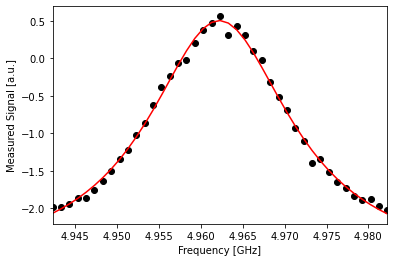

In [166]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [1, 4.975, 1, -2] # initial parameters for curve_fit
                                )

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [164]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.96227 GHz to 4.9622 GHz.


In [168]:
import qiskit.tools.jupyter
%qiskit_version_table

/Users/gott3rd4mmerung/opt/anaconda3/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
